In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc as misc
import pose_model

%matplotlib inline

RESIZE_DIM=368

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('model_dir', '/tmp/pose_train',
                           """Directory where model is stored.""")
tf.app.flags.DEFINE_string('image_file', 
                           '/Users/xuehan.xiong/Google Drive/datasets/human_pose/images/000001163.jpg',
                           """Absolute path to image file.""")

In [3]:
        
def resize_image(image):
    height,width = image.shape[:2]
    scale = float(RESIZE_DIM) / float(height)
    resized_image = cv2.resize(image,(0,0),fx=scale,fy=scale)
    assert resized_image.shape[0] == RESIZE_DIM
    return resized_image

def preprocess(image):
    image = np.float32(image)
    image = image * (1. / 255) - 0.5
    return image

In [4]:
image_path = FLAGS.image_file;
if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
image_data = cv2.imread(image_path);
resized_image = resize_image(image_data)
resized_image = preprocess(resized_image)
assert resized_image.shape[2] == 3
height,width = resized_image.shape[:2]
resized_image = np.reshape(resized_image,(1,height,width,3))

(1, 368, 654, 3)
(1, 46, 81, 15)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.193303
0.0


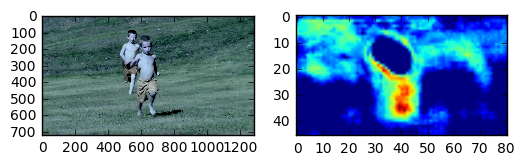

In [19]:
with tf.Graph().as_default():
    image_placeholder = tf.placeholder(tf.float32, shape=(None,None,None,3))
    heatmaps0,heatmaps1 = pose_model.inference(image_placeholder,0.0)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model_checkpoint_path = os.path.join(FLAGS.model_dir,'model.ckpt-6964')
        saver.restore(sess, model_checkpoint_path)
        heatmaps0_val,heatmaps1_val = sess.run([heatmaps0,heatmaps1], 
                                               feed_dict={image_placeholder: resized_image})
        print resized_image.shape
        print heatmaps0_val.shape
        print heatmaps1_val[0,:,:,0]
        print np.amax(heatmaps1_val[:,:,:,0])
        print np.amin(heatmaps1_val[:,:,:,0])
        plt.subplot(121)
        plt.imshow(image_data)
        plt.subplot(122)
        plt.imshow(heatmaps0_val[0,:,:,11])
        plt.show()
        
        